<a href="https://colab.research.google.com/github/SzeKiatTan/acv-unet-depth-prediction/blob/main/ACV_U_Net_Depth_Prediction_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth Estimation Using U-NET
*Sze Kiat Tan - Reddragon AI ACV Dec 2020*

---
<br>

Using a 5-block U-Net architecture; this project aims to estimate depth from a single monocular image.
<br><br>

The dataset used for training and evaluation is the **[NYU Depth V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)** labelled set [1], consisting of 1449 densely labeled pairs of aligned RGB and depth images.

<br>


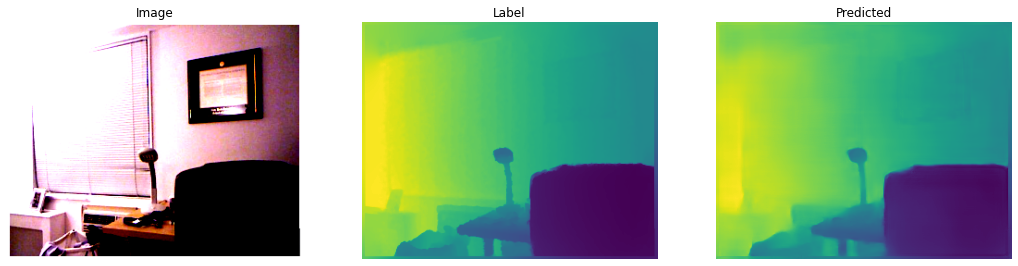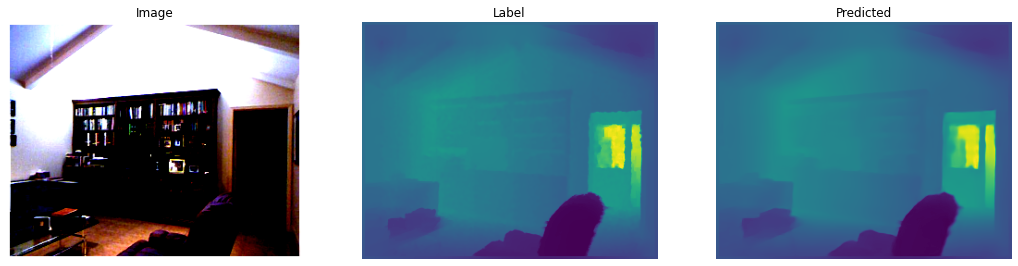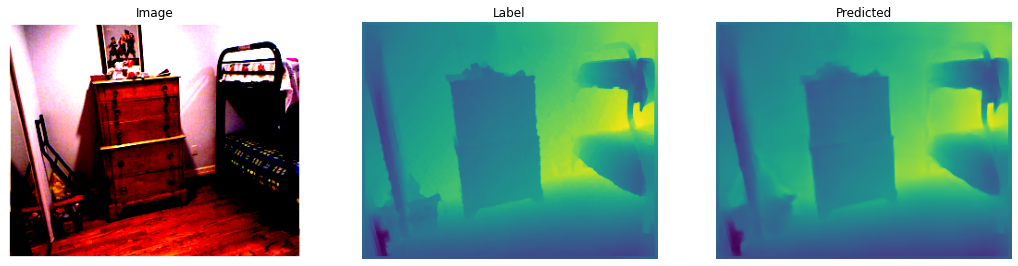


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# To download the dataset if needed

# !wget -qq http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
# !ls

In [ ]:
PROJ_FOLDER = '/gdrive/My Drive/Colab Notebooks/ACV/'

!ls '/gdrive/My Drive/Colab Notebooks/ACV'

model  nyu_depth_v2_labeled.mat  project  results  training


In [ ]:
!nvidia-smi

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import pickle 
import glob
import cv2

import random
import os
from PIL import Image

import scipy.io as sio
import h5py
import math
import sys

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, Callback


In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

## Image Preprocessing

We first load and format the images into numpy arrays. To facilitate training times with the limited GPU resource available here, we reduce the resolution by half--from 640x480 to 320x256. 

At the same time we perform the following transforms on the RGB and Depth images:

*   RGB: normalise and subtract the mean and std deviation
*   Depth: clip values between 0 and specifiable max depth, and normalise values to between 0 to 1.



In [ ]:
f = h5py.File(PROJ_FOLDER + 'nyu_depth_v2_labeled.mat', 'r')
    
f.keys()


<KeysViewHDF5 ['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']>

In [ ]:
HEIGHT = 256
WIDTH = 320

def rgb_transform(images, width=WIDTH, height=HEIGHT):
  results = []
  images = np.swapaxes(images, 1,3)
  
  for img in images:
    img = img / 255.0
    results.append(cv2.resize(img, (width, height)))
  
  results = np.asarray(results)
  results -= results.mean()
  results /= results.std()

  return results


def depth_transform(depths, width=WIDTH, height=HEIGHT, max_dist=10.0):
  results = []
  depths = np.swapaxes(depths, 1,2)
  for depth in depths:
    depth = np.clip(depth, 0, max_dist)
    depth = depth / max_dist
    # depth = np.array(depth * 255.0, dtype=np.uint8)
    depth = cv2.resize(depth, (width, height))
    # depth = np.log(depth)

    results.append(depth)

    # bgr_depth_img = cv2.cvtColor(depth, cv2.COLOR_GRAY2BGR) 
    # results.append(np.clip(bgr_depth_img, 0, 255))

  return np.asarray(results)

In [ ]:
nyu_imgs = rgb_transform(f['images'])

print("images shape:", nyu_imgs.shape)

images shape: (1449, 256, 320, 3)


In [ ]:
nyu_depths = depth_transform(f['depths'])

print("depths shape:", nyu_depths.shape)

N, ROWS, COLS = nyu_depths.shape


depths shape: (1449, 256, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


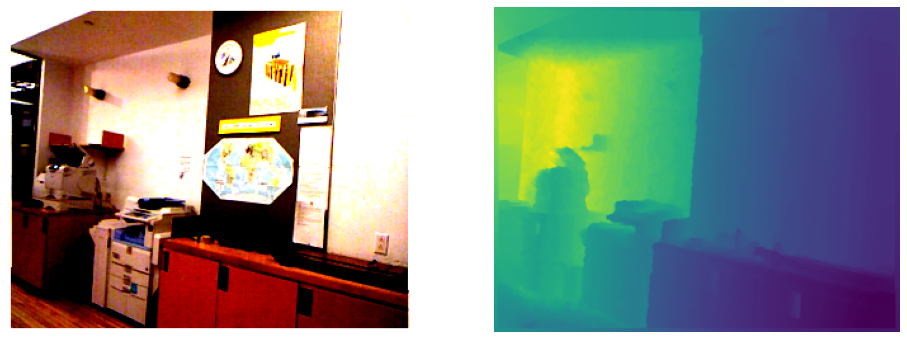

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(nyu_imgs[36]);
ax2.imshow(nyu_depths[36])
ax1.axis("off");
ax2.axis("off"); 
plt.axis("off");

## Dataset Pipeline 

Here we define the train-validation split ratio **(0.9)** and the batch size **(8)**.

We also define the tf dataset for training and validation.

In [ ]:
train_val_n = math.ceil(N*0.9)

BATCH_SZ = 8                    # batch size for training
n_pixels = ROWS * COLS
n_loss = n_pixels * BATCH_SZ

print(train_val_n, ROWS, COLS, n_pixels)

1305 256 320 81920


In [ ]:
def _parse_function(image,label):
  label_image_resized = tf.reshape(label,[n_pixels,1])
  return image, label_image_resized

In [ ]:
def train_set(n, imgs, lbls):
  train_dataset = tf.data.Dataset.from_tensor_slices((imgs[:n], lbls[:n]))
  train_dataset = train_dataset.map(_parse_function)
  train_dataset = train_dataset.shuffle(N, reshuffle_each_iteration=True)
  train_dataset = train_dataset.repeat(1000)
  train_dataset = train_dataset.batch(BATCH_SZ, drop_remainder = False)
  return train_dataset


In [ ]:
def valid_set(n, imgs, lbls):
  valid_dataset = tf.data.Dataset.from_tensor_slices((imgs[n:], lbls[n:]))
  valid_dataset = valid_dataset.map(_parse_function)
  # valid_dataset = valid_dataset.shuffle(N, reshuffle_each_iteration=True)
  valid_dataset = valid_dataset.repeat(1000)
  valid_dataset = valid_dataset.batch(BATCH_SZ, drop_remainder = False)
  return valid_dataset

## Model

Here we define two variants of U-Net models. 

<br>


1.   For the first variant, we adapted the U-Net model from the Camvid U-Net example, modifying the output to produce a depth map instead of a segment label.

2.   For the second variant, we used T-Net blocks as skip connections instead; as adapted from [2]

<br>

We also defined two custom loss functions for experimentation based on related literature: **scale-invariant** [3] and the **reverse-huber (berhu)** [4, 5] loss. They were proposed by their authors to produce better results than simply using MSE loss.




In [ ]:
# U-Net 

input_shape = (HEIGHT, WIDTH, 3)
batch_size = None

Inp = tf.keras.Input(
      name='unet_input', 
      shape=input_shape, 
      batch_size=batch_size, 
      dtype=tf.float32
      )
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(Inp)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6)

# up
up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv5], axis=3)
conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv4], axis=3)
conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv3], axis=3)
conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

up10 = concatenate([UpSampling2D(size=(2, 2))(conv9), conv2], axis=3)
conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

up11 = concatenate([UpSampling2D(size=(2, 2))(conv10), conv1], axis=3)
conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)

# pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)

conv12 = Conv2D(1, (1, 1))(conv11)
conv12 = Reshape((-1, 1))(conv12) #flatten
conv12 = Activation('relu')(conv12)
 

In [ ]:
# U-Net with T-Net links

def T_Net(x, k_size, block_name):
  n = x.shape[3]
  x = Conv2D(filters=n/2, kernel_size=k_size, padding='same', activation='relu',name=block_name + '_01')(x)
  x = Conv2D(filters=n, kernel_size=k_size, padding='same', activation='relu',name=block_name + '_02')(x)
  return x

input_shape = (HEIGHT, WIDTH, 3)
batch_size = None

Inp = tf.keras.Input(
      name='unet_input', 
      shape=input_shape, 
      batch_size=batch_size, 
      dtype=tf.float32
      )
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(Inp)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6)

# up
up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), T_Net(conv5, 3, 'tnet1')], axis=3)
conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), T_Net(conv4, 3, 'tnet2')], axis=3)
conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), T_Net(conv3, 3, 'tnet3')], axis=3)
conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

up10 = concatenate([UpSampling2D(size=(2, 2))(conv9), T_Net(conv2, 5, 'tnet4')], axis=3)
conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

up11 = concatenate([UpSampling2D(size=(2, 2))(conv10), T_Net(conv1, 5, 'tnet5')], axis=3)
conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)

# pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)

conv12 = Conv2D(1, (1, 1))(conv11)
conv12 = Reshape((-1, 1))(conv12) #flatten
conv12 = Activation('relu')(conv12)



In [ ]:
# Custom Loss functions

def scale_invariant_loss(d_actual, d_pred):
  di = tf.math.log1p(d_pred) - tf.math.log1p(d_actual)
  # di = d_pred - d_actual
  di2 = tf.math.pow(di, 2)
  first_term = tf.math.reduce_sum(di2) / (n_loss)
  second_term = tf.math.pow(tf.math.reduce_sum(di), 2) / (2*n_loss*n_loss)
  scale_invariant_loss = first_term - second_term
  return scale_invariant_loss

def berhu_loss(d_actual, d_pred):
  di = tf.math.abs(d_pred - d_actual)
  c = 0.05 * tf.math.reduce_max(di)
  l2 = ((di*di) + (c*c)) / (2*c)
  berhu_loss = tf.math.reduce_mean(tf.where(tf.less_equal(di, c), di, l2))
  return berhu_loss

In [ ]:
model = Model(inputs=[Inp], outputs=[conv12])

In [ ]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)  
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-8)

# model.compile(optimizer=opt, loss='MSE', metrics=[tf.keras.metrics.RootMeanSquaredError()])
# model.compile(optimizer=opt, loss=berhu_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.compile(optimizer=opt, loss=scale_invariant_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unet_input (InputLayer)         [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 320, 32) 896         unet_input[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 320, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 160, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Training

We first train the model for 20 epochs to get a sensing of whether it is converging in the right direction (using the *Prediction and Evaluation* section to observe the model output qualitatively).

In [ ]:
# model.load_weights(PROJ_FOLDER + 'training/BS8_RELU_RMSPropOpt_EP130_RMS0.1377.hdf5')

In [ ]:
EPOCHS = 20

history = model.fit(train_set(train_val_n, nyu_imgs, nyu_depths), 
                        steps_per_epoch=200, 
                        epochs=EPOCHS,
                        validation_data=valid_set(train_val_n, nyu_imgs, nyu_depths), 
                        validation_steps=10
                       )

Epoch 1/20
200/200 [==============================] - 34s 156ms/step - loss: 0.0131 - root_mean_squared_error: 0.1638 - val_loss: 0.0079 - val_root_mean_squared_error: 0.1317
Epoch 2/20
200/200 [==============================] - 31s 154ms/step - loss: 0.0077 - root_mean_squared_error: 0.1233 - val_loss: 0.0085 - val_root_mean_squared_error: 0.1394
Epoch 3/20
200/200 [==============================] - 31s 155ms/step - loss: 0.0069 - root_mean_squared_error: 0.1168 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1559
Epoch 4/20
200/200 [==============================] - 31s 154ms/step - loss: 0.0063 - root_mean_squared_error: 0.1102 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1604
Epoch 5/20
200/200 [==============================] - 31s 155ms/step - loss: 0.0062 - root_mean_squared_error: 0.1105 - val_loss: 0.0083 - val_root_mean_squared_error: 0.1355
Epoch 6/20
200/200 [==============================] - 31s 154ms/step - loss: 0.0056 - root_mean_squared_error: 0.1031 - val_l

In [ ]:
model.evaluate(valid_set(train_val_n, nyu_imgs, nyu_depths), steps=20)

20/20 [==============================] - 1s 58ms/step - loss: 0.0057 - root_mean_squared_error: 0.1081


[0.005743507761508226, 0.10805054008960724]

In [ ]:
# model.save_weights(PROJ_FOLDER + 'training/BS8_TNET_MSE_EP40_RMS0.1072.hdf5')

## Further Training

We then proceed with further training to let the model converge, using auto checkpoints to save the model where appropriate.

In [ ]:
EPOCHS = 80

history = model.fit(train_set(train_val_n, nyu_imgs, nyu_depths), 
                        steps_per_epoch=200, 
                        epochs=EPOCHS,
                        validation_data=valid_set(train_val_n, nyu_imgs, nyu_depths), 
                        validation_steps=10
                       )

Epoch 1/80
200/200 [==============================] - 34s 154ms/step - loss: 6.6829e-05 - root_mean_squared_error: 0.0118 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1079
Epoch 2/80
200/200 [==============================] - 30s 152ms/step - loss: 4.8384e-05 - root_mean_squared_error: 0.0098 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1075
Epoch 3/80
200/200 [==============================] - 31s 153ms/step - loss: 3.9606e-05 - root_mean_squared_error: 0.0087 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1079
Epoch 4/80
200/200 [==============================] - 31s 153ms/step - loss: 3.5368e-05 - root_mean_squared_error: 0.0082 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1073
Epoch 5/80
200/200 [==============================] - 31s 153ms/step - loss: 3.2095e-05 - root_mean_squared_error: 0.0078 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1081
Epoch 6/80
200/200 [==============================] - 31s 153ms/step - loss: 3.0316e-05 - root_mean_squar

In [ ]:
model.evaluate(valid_set(train_val_n, nyu_imgs, nyu_depths), steps=20)

20/20 [==============================] - 1s 59ms/step - loss: 0.0053 - root_mean_squared_error: 0.1049


[0.005293133668601513, 0.10487976670265198]

In [ ]:
model.save_weights(PROJ_FOLDER + 'training/BS8_invariant_AdamOpt_fine_EP180_RMS0.1049.hdf5')

In [ ]:
checkpoint = ModelCheckpoint(PROJ_FOLDER + 'training/BS8_BERHU_RMSOpt_EP{epoch:3d}_{val_root_mean_squared_error:.4f}_AUTO.hdf5', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

In [ ]:
# model.load_weights(PROJ_FOLDER + 'training/BS8_invariant_AdamOpt_EP100_RMS0.1095.hdf5')

In [ ]:
EPOCHS = 100

history = model.fit(train_set(train_val_n, nyu_imgs, nyu_depths), 
                        steps_per_epoch=200, 
                        epochs=EPOCHS,
                        validation_data=valid_set(train_val_n, nyu_imgs, nyu_depths), 
                        validation_steps=10
                        #callbacks=[checkpoint]
                       )

Epoch 1/100
200/200 [==============================] - 32s 151ms/step - loss: 3.2683e-05 - root_mean_squared_error: 0.0082 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1061
Epoch 2/100
200/200 [==============================] - 30s 151ms/step - loss: 2.4372e-05 - root_mean_squared_error: 0.0071 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1065
Epoch 3/100
200/200 [==============================] - 30s 151ms/step - loss: 2.0955e-05 - root_mean_squared_error: 0.0065 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1062
Epoch 4/100
200/200 [==============================] - 30s 151ms/step - loss: 1.8048e-05 - root_mean_squared_error: 0.0060 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1063
Epoch 5/100
200/200 [==============================] - 30s 151ms/step - loss: 1.6854e-05 - root_mean_squared_error: 0.0058 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1064
Epoch 6/100
200/200 [==============================] - 30s 151ms/step - loss: 1.5102e-05 - root_mean

In [ ]:
model.evaluate(valid_set(train_val_n, nyu_imgs, nyu_depths), steps=20)

20/20 [==============================] - 2s 71ms/step - loss: 0.0054 - root_mean_squared_error: 0.1048


[0.0053993938490748405, 0.10475902259349823]

In [ ]:
model.save(PROJ_FOLDER + 'model/BS8_TNET_invariant_AdamOpt_EP200.h5')

In [ ]:
model.load_weights(PROJ_FOLDER + 'training/BS8_TNET_invariant_AdamOpt_EP200_RMS0.1048.hdf5')

## Prediction and Evaluation

Here we use the trained model to predict the depths of a series of validation set images, and print out a sample to see the qualitative results.

From the table below, it shows that we have the most success using scale-invariant loss to optimise the model, giving the lowest RMS error. 

<br>

U-Net Model

| Loss Function | Optimizer | Epochs | Val 20 steps RMSE |
|---|---|---|---|
| MSE | RMSProp | 230 | 0.1321 |
| BERHU | RMSProp | 200 | 0.1143 |
| BERHU | Adam | 200 | 0.1057 |
| Scale-invariant | Adam | 200 | 0.1043 |

<br>

U-Net with T-Net 

| Loss Funtion | Optimizer | Epochs | Val 20 steps RMSE |
|---|---|---|---|
| MSE | RMSProp | 200 | 0.1197 |
| BERHU | RMSProp | 200 | 0.1187 |
| BERHU | Adam | 200 | 0.1065 |
| **Scale-invariant** | **Adam** | **200** | **0.1048** |


Qualitatively, even though the T-Net model has a slightly higher RMSE, we observe that it captures the scene details (counter-tops, chairs, table clutter) slightly better. Hence the T-Net model with scale-invariant loss (bold above) was our preferred combination.


<br>


In [ ]:
images_for_preds = []
real_labels = []
NUM_STEPS_PRED = 10

for i, (image,label) in enumerate(valid_set(train_val_n, nyu_imgs, nyu_depths)):
  images_for_preds.append(image.numpy())
  real_labels.append(label.numpy())
  if i==NUM_STEPS_PRED-1:
    break


In [ ]:
images_4_preds = np.asarray(images_for_preds)

images_4_preds = np.reshape(images_4_preds,[NUM_STEPS_PRED*BATCH_SZ,HEIGHT,WIDTH,3])

images_4_preds.shape

(80, 256, 320, 3)

In [ ]:
real_labels_img = np.asarray(real_labels)

real_labels_img = np.reshape(real_labels, [NUM_STEPS_PRED*BATCH_SZ,HEIGHT,WIDTH])

real_labels_img.shape

(80, 256, 320)

In [ ]:
preds = model.predict(images_4_preds, batch_size=BATCH_SZ, steps=NUM_STEPS_PRED)

In [ ]:
preds2 = np.reshape(preds, [NUM_STEPS_PRED*BATCH_SZ,HEIGHT,WIDTH])

preds2.shape

(80, 256, 320)

In [ ]:
def plot_images(image_number):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
    ax1.imshow(images_4_preds[image_number])
    ax2.imshow(real_labels_img[image_number])
    ax3.imshow(preds2[image_number])
    ax1.axis("off");
    ax2.axis("off"); 
    ax3.axis("off"); 
    plt.axis("off");
    ax1.title.set_text("Image");
    ax2.title.set_text("Label");
    ax3.title.set_text("Predicted");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


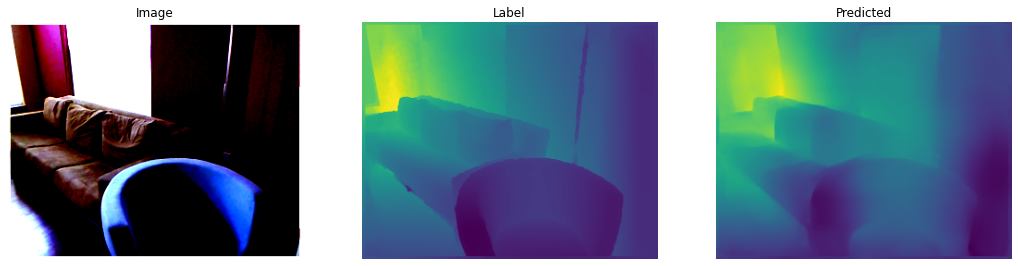

In [ ]:
image_number = 8
plot_images(image_number)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


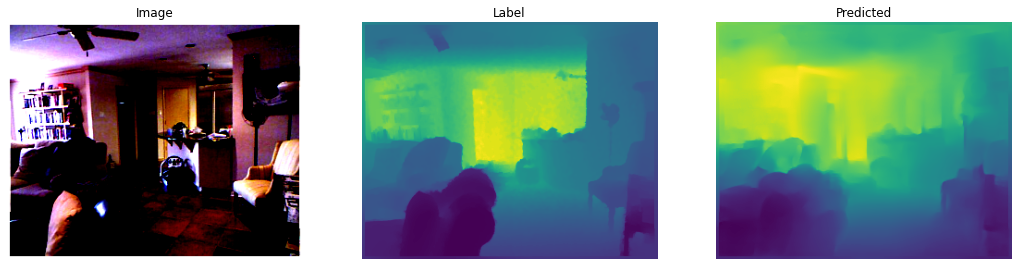

In [ ]:
image_number = 30
plot_images(image_number)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


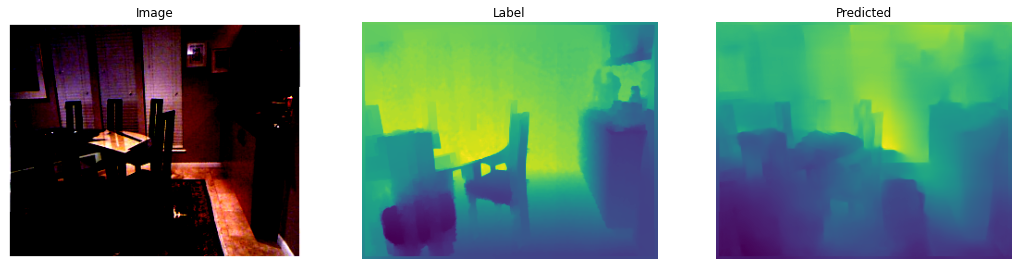

In [ ]:
image_number = 50
plot_images(image_number)

## References

[1] P. K. Nathan Silberman, Derek Hoiem and R. Fergus, “Indoor segmentation
and support inference from rgbd images,” in ECCV, 2012.

[2] L. He, G. Wang, and Z. Hu, “Learning depth from single images
with deep neural network embedding focal length,” IEEE Transactions on Image Processing, vol. 27, no. 9, pp. 4676–4689, 2018

[3] D. Eigen, C. Puhrsch, and R. Fergus, “Depth map prediction from a single image using a multi-scale deep network,” in Advances in neural information processing systems, 2014, pp. 2366–2374

[4] L. Zwald and S. Lambert-Lacroix. The berhu penalty and the grouped effect. arXiv preprint arXiv:1207.6868, 2012.

[5] I. Laina, C. Rupprecht, V. Belagiannis, F. Tombari, and N. Navab, “Deeper depth prediction with fully convolutional residual networks,” in 3D Vision (3DV), 2016 Fourth International Conference on. IEEE, 2016, pp. 239–248.